**Kapitel 2 – Ende-zu-Ende Machine Learning Projekt**

*Willkommen bei der Machine Learning Housing Corp. Ihre Aufgabe ist es, den Medianwert von Häusern in kalifornischen Bezirken anhand einer Reihe von Merkmalen aus diesen Bezirken vorherzusagen.

*Dieses Notizbuch enthält den gesamten Beispielcode und die Lösungen zu den Übungen in Kapitel 2.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

Zunächst importieren wir einige gängige Module, stellen sicher, dass MatplotLib Zahlen inline plottet und bereiten eine Funktion zum Speichern der Zahlen vor. Wir überprüfen auch, ob Python 3.5 oder höher installiert ist (Python 2.x kann zwar funktionieren, ist aber veraltet, so dass wir dringend empfehlen, stattdessen Python 3 zu verwenden), sowie Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Datenbeschaffung

## Download der Daten

In [2]:
# Code zum Downloaden der Daten bon Github (+ Entpacken)
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# Funktion fetch_housing_data ausführen
fetch_housing_data()

In [4]:
# Schreibe eine Funktion load_housing_data zum Laden der Daten als pandas DataFrame

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Ein kurzer Blick auf die Struktur der Daten

In [5]:
# Lade die Daten und zeige die ersten samples
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# Zeige eine Zusammenfassung der verfügbaren Spalten
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# Welche Werte nimmt die Spalte "ocean_proximity" an?
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# Zeige eine statistische Zusammenfassung aller numerischen Spalten
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


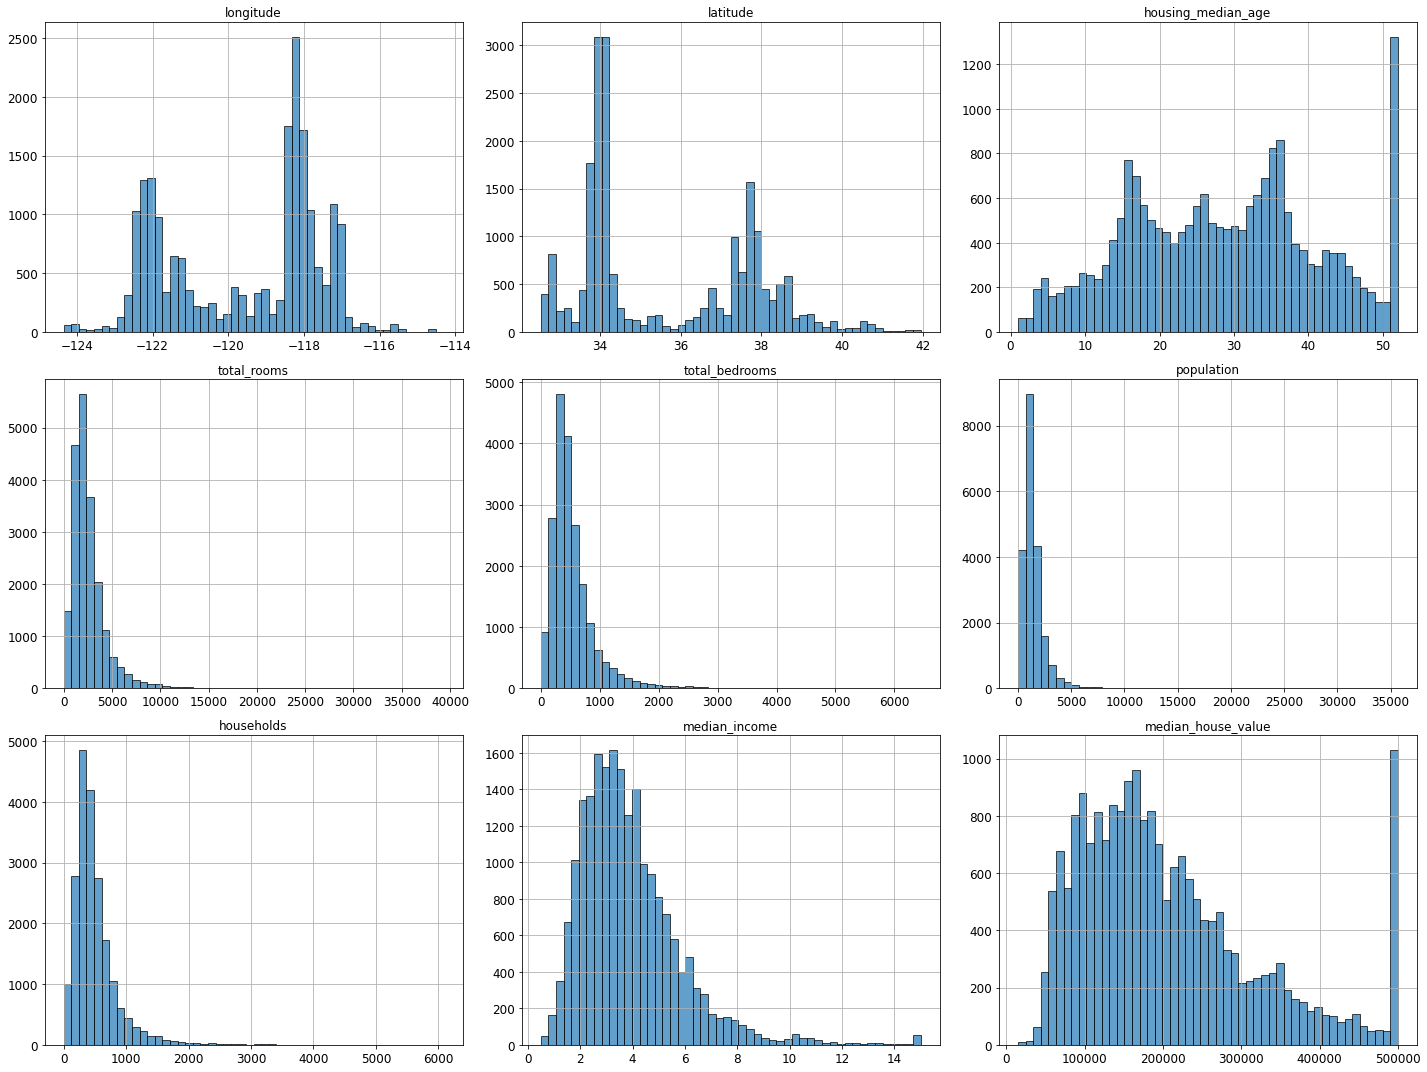

In [9]:
# Visualisiere alle Features als Histogramm
# Hinweis: pandas hat eigene plotting Funktionen!
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15), edgecolor="k", alpha=0.7)
save_fig("attribute_histogram_plots")

## Erzeugen eines Test-Datensatzes

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [11]:
# Erzeuge ein Trainings- und Test-Datensatz mit Hilfe von sklearn train_test_split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
# Schaue dir den Testdatensatz an
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot:>

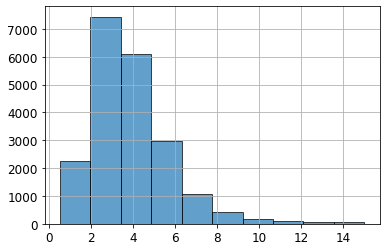

In [13]:
# Visualisiere die Spalte "median_income"
housing["median_income"].hist(edgecolor="k", alpha=0.7)

In [14]:
# Diskretisiere die Werte in "median_income" anhand der Bins [0., 1.5, 3.0, 4.5, 6., np.inf]
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [15]:
# Zeige die Verteilung der neuen Spalte "income_cat"
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

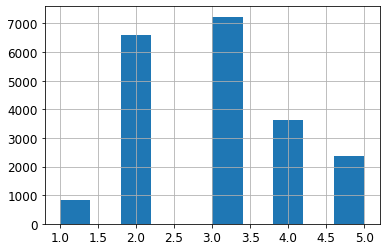

In [16]:
# und als Histogramm
housing["income_cat"].hist()

In [17]:
# Führe einen stratified split durch
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [18]:
# Zeige den Prozentsatz an Daten pro Ausprägung von "income_cat" im strat_test_set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [19]:
# Zeige den Prozentsatz an Daten pro Ausprägung von "income_cat" im Originaldatensatz housing
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [20]:
# Vergleiche die Zusammensetzung der Daten für Originaldatensatz, tratified und random split
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [21]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [22]:
# Entferne die Spalte "income_cat" aus dem Trainings- und Testdatensatz
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Explorative Datenanalyse durchführen

In [23]:
# Speichere eine Kopie vom Trainingsdatensatz als housing
housing = strat_train_set.copy()

## Visualisieren von Geo-Daten

Saving figure bad_visualization_plot


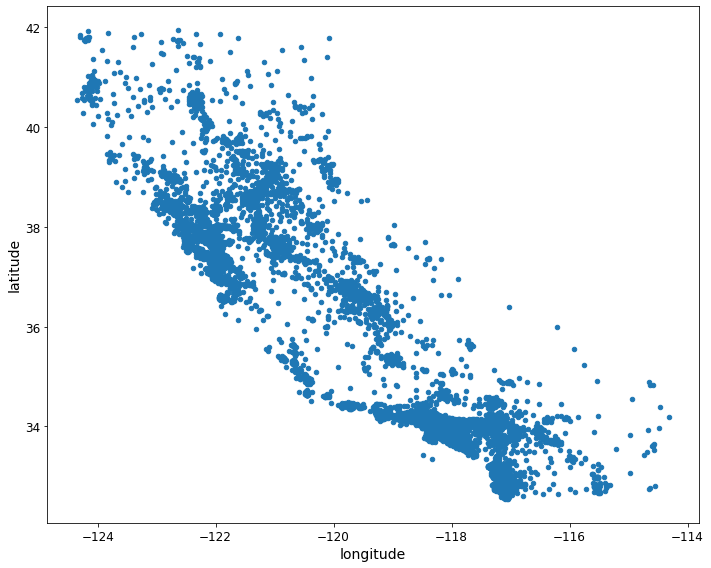

In [24]:
# Erzeuge einen Scatterplot aus den Koordinaten
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10, 8))
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


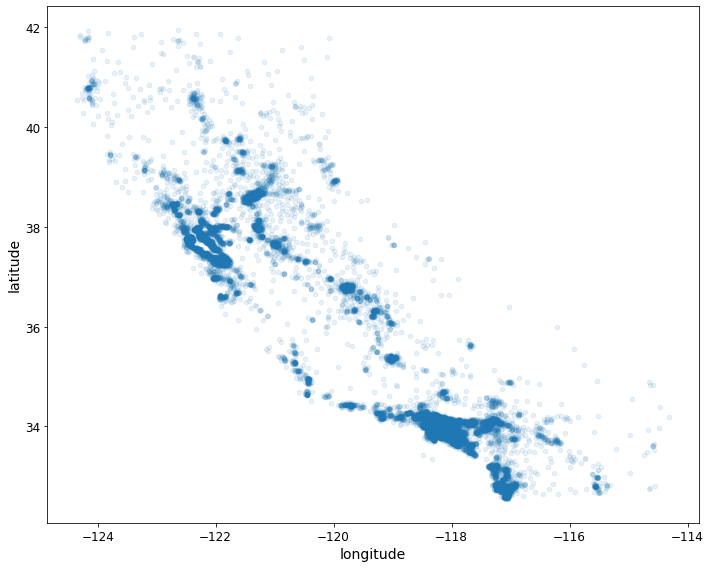

In [25]:
# Verbessere die Visualisierung durch geeignete Transparenz
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10, 8))
save_fig("better_visualization_plot")

Das Argument `sharex=False` behebt einen Anzeigefehler (Die $x$-Achsenwerte und die Legende werden nicht angezeigt). Das ist ein temporärer Fix (siehe: https://github.com/pandas-dev/pandas/issues/10611 ). Danke an Wilmer Arellano für den Hinweis.

Saving figure housing_prices_scatterplot


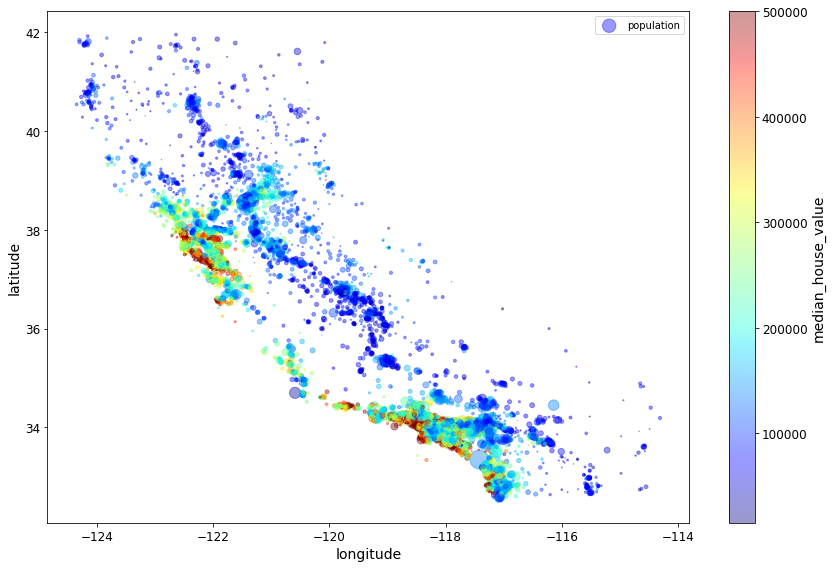

In [26]:
# Verbessere die Grafik weiter durch Einfärbung nach "median_house_value" sowie Zuordnung der Populationsgröße als Durchmesser
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(12,8),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [27]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7ff250bb3f40>)

Saving figure california_housing_prices_plot


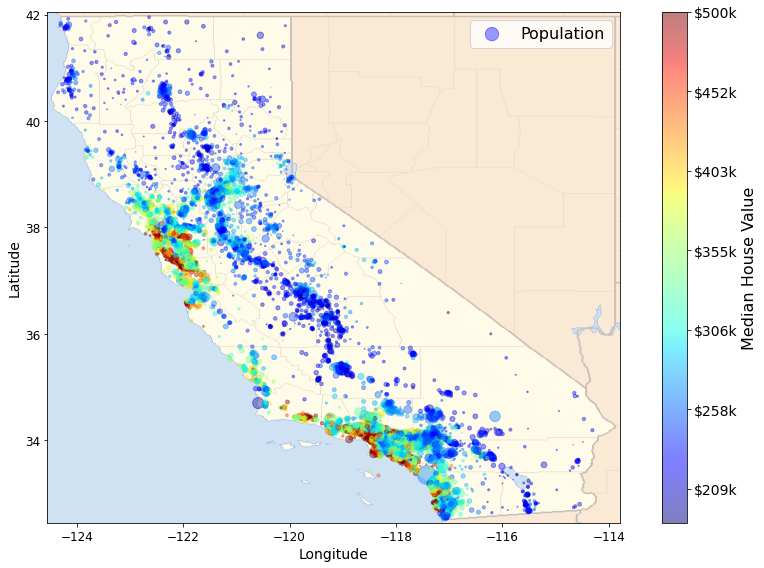

In [28]:
# Hinterlege den Scatterplot mit der heruntergeladenen Karte
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(12,8),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")

## Auf der Suche nach Korrelationen

In [29]:
# Erzeuge eine Korrelationsmatrix
corr_matrix = housing.corr()

In [30]:
# Betrachte die Korrelation zwischen den Features und dem target
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


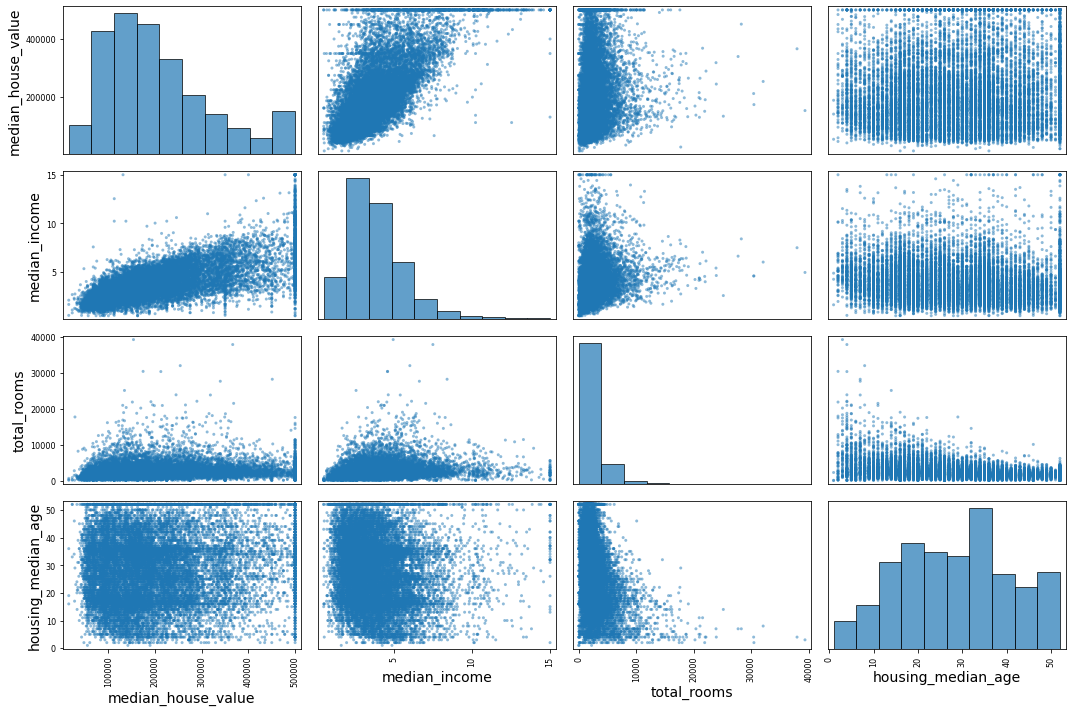

In [31]:
# Erstelle eine scatterplot matrix für housing für die Features ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15, 10), hist_kwds={"edgecolor": "k", "alpha": 0.7})
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


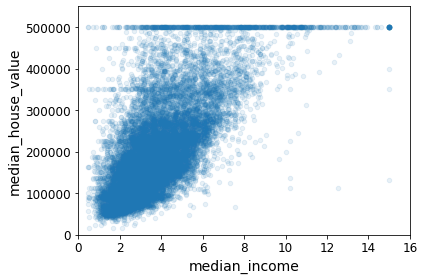

In [32]:
# Erzeuge einen Scatterplot für "median_income" und "median_house_value"
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

## Experimentieren mit zusätzlichen Attributen

In [33]:
# Erzeuge 3 neue Attribute "rooms_per_household", "bedrooms_per_room", "population_per_household"
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [34]:
# Bestimme die Korrelation zwischen den neuen Attributen und dem target
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

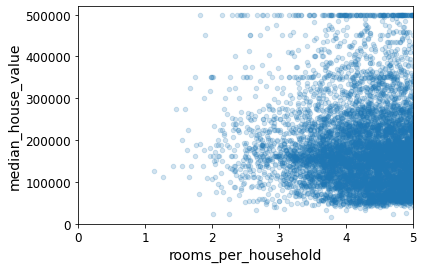

In [35]:
# Visualisiere den Zusammenhang zwischen dem neuen Feature "rooms_per_household" und dem target
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [36]:
# Zeige die statistische Zusammenfassung der numerischen Spalten
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Die Daten für Machine Learning Algorithmen vorbereiten

In [37]:
# Entferne das target von den Trainingsdaten
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

Im Buch werden drei Wege gezeigt, mit fehlenden Werten umzugehen

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

Um alle drei Wege zu demonstrieren, erzeugen wir zuerst eine Kopie des housing Datensatzes, aber nur für diejenigen Zeilen, die mindestens einen fehlenden Wert enthalten. Das erleichtert das Verständnis, was jede Option genau tut:

In [38]:
# Erzeuge eine Kopie von housing für die Zeilen mit fehlenden Werten
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [39]:
# Nutze dropna um Zeilen zu entfernen
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [40]:
# Nutze drop um Spalten zu entfernen
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [41]:
# Fülle die fehlenden Werte in "total_bedrooms" mit dem Median der Spalte auf
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [42]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [43]:
# Instanziiere einen SimpleImputer von sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [44]:
# Versuche, den Imputer auf dem Datensatz zu trainieren
imputer.fit(housing)

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'INLAND'

Wir müssen für den Imputer alle Text-Features entfernen, da der Median nur für numerische Attribute berechnet werden kann:

In [45]:
# Entferne die Text-Attribute und speichere alle numerischen Attribute in housing_num
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [46]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [47]:
# Zeige die Statistiken des Imputers
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Wir überprüfen noch, dass der Imputer identische Ergebnisse liefert wie eine manuelle Berechnung des Medians:

In [48]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Jetzt können wir den Datensatz transformieren (Wichtig: Immer nur auf dem Trainingsdatensatz trainieren!)

In [49]:
# Transformiere housing_num mittels Imputer
X = imputer.transform(housing_num)

In [50]:
# Erzeuge wieder ein pandas DataFrame aus X mit den Spalten von housing_num und dem Index von housing
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [51]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [52]:
# Überprüfe, dass die fehlenden Werte jetzt aufgefüllt wurden
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [53]:
imputer.strategy

'median'

## Umgang mit Text and Kategorischen Attributen

Jetzt werden wir das kategorische Feature "ocean_proximity" näher betrachten:

In [54]:
# Zeige die ersten Einträge für "ocean_proximity"
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [55]:
# Nutze den OrdinalEncoder von sklearn um die Spalte "ocean_proximity" in ein ordinal-skaliertes kategorisches Attribut umzuwandeln
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [56]:
# Zeige die Kategorien des encoders
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [57]:
# Nutze den OneHotEncoder von sklearn, um die Spalte "ocean_proximity" zu one-hot-encoden
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder() # sparse=True ist der Default
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Standardmäßig gibt die `OneHotEncoder` Klasse ein sparse array zurück. Dieses können wir aber in ein dense array umwandeln, indem wir die `toarray()` Methode aufrufen:

In [58]:
# Wandle die sparse Matrix in eine dense Matrix um
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternativ können wir auch direkt `sparse=False` setzen, wenn wir eine neue Instanz von `OneHotEncoder` erzeugen:

In [59]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [60]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [61]:
# Nutze pandas get_dummies für OneHotEncoding
pd.get_dummies(housing_cat)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,0,1,0,0,0
15502,0,0,0,0,1
2908,0,1,0,0,0
14053,0,0,0,0,1
20496,1,0,0,0,0
...,...,...,...,...,...
15174,1,0,0,0,0
12661,0,1,0,0,0
19263,1,0,0,0,0
19140,1,0,0,0,0


## Eigene Transformer schreiben

Let's create a custom transformer to add extra attributes:

In [62]:
# Für Fortgeschrittene: Erzeuge einen eigenen Transformer mit eigenen Parametern
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X, rooms_per_household, population_per_household, bedrooms_per_room
            ]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [63]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

Beachte, dass hier die Indizes `(3, 4, 5, 6)` hardcecoded wurden für eine bessere Lesbarkeit im Buch. Es wäre natürlich viel besser, diese dynamisch auszulesen, zum Beispiel auf diese Weise:

In [64]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

Außerdem ist `housing_extra_attribs` ein NumPy array und wir verlieren dadurch die Spaltennamen (leider ein gängiges Problem mit Scikit-Learn). Um wieder ein `DataFrame` zu erhalten, kann man den folgenden Code ausführen:

In [65]:
# Erzeuge wieder ein pandas DataFrame aus unserem Numpy array
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


## Transformation Pipelines

Jetzt bauen wir eine Vorverarbeitungs-Pipeline für die numerischen Attribute:

In [66]:
# Nutze Pipeline von sklearn, um eine Pipeline aufzubauen, die zuerst einen Imputer nutzt, dann unseren CombinedAttributesAdder und als letztes einen StandardScaler
# transformiere die numerischen Trainingsdaten
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [67]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [68]:
# Nutze einen ColumnTransformer von sklearn, um sowohl numerische als auch kategorische Attribute auf einmal zu verarbeiten
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [69]:
# Zeige die pipeline -> Dank der neuen Version eine echt tolle Hilfe!
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])

In [70]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [71]:
# Zeige die Dimension von housing_prepared
housing_prepared.shape

(16512, 16)

# Auswahl und Training eines Modells

## Training und Evaluierung auf dem Trainings-Datensatz

In [72]:
# Trainiere eine einfache lineare Regression auf dem Trainingsdatensatz
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [73]:
# Teste die gesamte Pipeline auf einigen Trainingsinstanzen und sage den Preis vorher
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


Vergleichen wir das mit den wahren Werten:

In [74]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [75]:
# Nutze mean_squared_error von sklearn.metrics um die Abweichung auf dem Trainingsdatensatz zu bestimmen
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) # oder squared=False
lin_rmse

68627.87390018745

**Note**: seit Scikit-Learn 0.22 kann der RMSE-Wert direkt ausgegeben werden, wenn man die `mean_squared_error()` Funktion mit `squared=False` aufruft.

In [76]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae


49438.66860915802

In [77]:
# Trainiere einen DecisionTreeRegressio auf den Trainingsdaten
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [78]:
# Bestimme den RMSE
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Bessere Evaluierung mit Cross-Validation

In [79]:
# Nutze cross_val_score von sklearn um Cross-Validation durchzuführen
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [80]:
# Wie sehen die scores aus?
tree_rmse_scores

array([72831.45749112, 69973.18438322, 69528.56551415, 72517.78229792,
       69145.50006909, 79094.74123727, 68960.045444  , 73344.50225684,
       69826.02473916, 71077.09753998])

In [81]:
# Schreibe eine Funktion, um aus den Scores den Mittelwert und die Std zu bestimmen
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [82]:
# Wiederhole Cross-Validation für die lineare Regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


**Note**: Wir nutzen `n_estimators=100`, um zukunftssicher zu sein, da dies die Standardeinstellung in Scikit-Learn ab der Version 0.22 sein wird.

In [83]:
# Trainiere einen RandomForrestRegressor auf den Trainingsdaten
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [84]:
# Alternativ: Nutze die score Methode
forest_reg.score(housing_prepared, housing_labels)

0.9740139626391636

In [85]:
# Bestimme wieder den RMSE
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [86]:
# Bestimme den RMSE mittels Cross-Validation für RF -> läuft sehr lange!
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [87]:
pd.Series(forest_rmse_scores).describe()

count       10.000000
mean     50435.580921
std       2322.522327
min      47210.512698
25%      48682.893887
50%      50812.405036
75%      51872.228024
max      54055.908946
dtype: float64

In [88]:
# Bestimme die CV-Scores für lineare Regression und nutze pandas describe() für eine Auswertung
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69104.079982
std       3036.132517
min      64114.991664
25%      67077.398482
50%      68718.763507
75%      71357.022543
max      73997.080502
dtype: float64

In [89]:
# Trainiere eine lineare SVM auf den Trainingsdaten und bestimme den RMSE score
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

# Unser Modell feinabstimmen

## Grid Search

In [90]:
# Nutze GridSearchCV von sklearn um die Hyperparameter des RF feinabzustimmen -> Läuft ne Weile
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Beste Hyperparameter-Konfiguration:

In [91]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Bester Estimator

In [92]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Schauen wir uns den Score für jede Hyperparameter-Kombination während des Grid Search an:

In [93]:
# am besten noch sortiert
cvres = grid_search.cv_results_
for mean_score, params in sorted(zip(cvres["mean_test_score"], cvres["params"])):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
57831.136061214274 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
51278.37877140253 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
50187.243249265

In [94]:
# Stelle cv_results_ als DataFrame dar
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.065868,0.002899,0.004913,0.001988,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.189457,0.011282,0.010240,0.001406,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.540684,0.014373,0.028338,0.000515,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.100954,0.004191,0.003440,0.000274,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.307412,0.010772,0.009018,0.001055,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.950121,0.064342,0.032263,0.006535,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.154097,0.014647,0.004050,0.000447,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.462434,0.027508,0.010734,0.001419,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.184506,0.034989,0.026908,0.000972,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.165340,0.005237,0.002919,0.000123,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


## Randomized Search

In [95]:
# Nutze RandomizedSearchCV von sklearn um die Hyperparameter des RF feinabzustimmen -> Läuft noch länger
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff250b882e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff290e4a710>},
                   random_state=42, scoring='neg_mean_squared_error')

In [96]:
cvres = rnd_search.cv_results_
for mean_score, params in sorted(zip(cvres["mean_test_score"], cvres["params"])):
    print(np.sqrt(-mean_score), params)

65167.02018649492 {'max_features': 5, 'n_estimators': 2}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
49117.55344336652 {'max_features': 7, 'n_estimators': 180}


## Analysiere das beste Modell und dessen Fehler

In [97]:
# Analysiere die feature importance des besten Estimators
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

<BarContainer object of 16 artists>

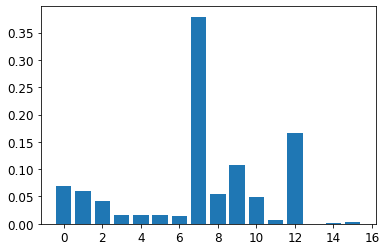

In [98]:
# Und als Histogramm
plt.bar(range(len(feature_importances)), feature_importances)

In [99]:
# Eine Möglichkeit, die Namen der feature mit der Importance zu verbinden
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204354, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887776, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

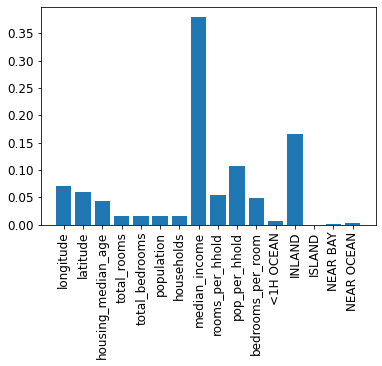

In [100]:
# Und als Histogramm mit feature names
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), attributes)
ax = plt.gca()
ax.tick_params(axis="x", rotation=90)

## Evaluiere das beste Modell auf dem Test-Datensatz

In [101]:
# Evaluiere das beste Modell auf dem Testdatensatz
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [102]:
final_rmse

47873.26095812988

Wir können ein 95%-Konfidenzintervall für den RMSE-Wert auf dem Test-Datensatz angeben:

In [103]:
# Nutze stats.t.interval von scipy für Bestimmung des 95%-CI
# Alternativ: Bootstrap
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

Wir können das Intervall auch manuell bestimmen:

In [104]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45893.3608282853, 49774.46796717339)

Alternativ könnten wir auch z-Scores statt t-scores verwenden:

In [105]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45893.954011012866, 49773.92103065016)

# Extra Material

## A full pipeline with both preparation and prediction

In [106]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

## Model persistence using joblib

In [107]:
my_model = full_pipeline_with_predictor

In [108]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

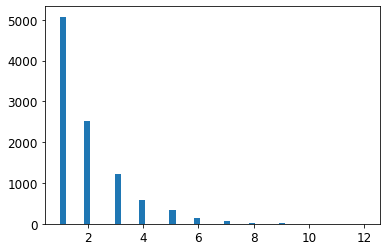

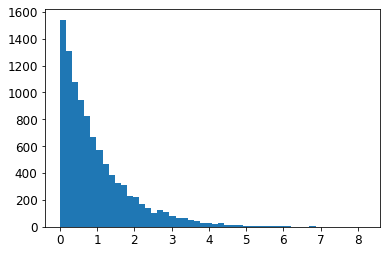

In [109]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Aufgabe: Probieren Sie einen Support Vector Machine Regressor (`sklearn.svm.SVR`) mit verschiedenen Hyperparametern aus, z.B. `kernel="linear"` (mit verschiedenen Werten für den Hyperparameter `C`) oder `kernel="rbf"` (mit verschiedenen Werten für die Hyperparameter `C` und `gamma`). Machen Sie sich vorerst keine Gedanken über die Bedeutung dieser Hyperparameter. Wie schneidet der beste `SVR`-Prädiktor ab?

**Warnung**: Die Ausführung der folgenden Zelle kann bis zu 30 Minuten dauern, je nach Ihrer Hardware auch länger.

In [111]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=8)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=30.0, kernel=linear; total time=  15.3s
[CV] END ..............................C=10.0, kernel=linear; total time=  15.4s
[CV] END ..............................C=30.0, kernel=linear; total time=  15.3s
[CV] END ..............................C=10.0, kernel=linear; total time=  15.5s
[CV] END ..............................C=10.0, kernel=linear; total time=  15.6s
[CV] END ..............................C=10.0, kernel=linear; total time=  15.6s
[CV] END ..............................C=30.0, kernel=linear; total time=  15.6s
[CV] END ..............................C=10.0, kernel=linear; total time=  15.7s
[CV] END ..............................C=30.0, kernel=linear; total time=  15.6s
[CV] END .............................C=100.0, kernel=linear; total time=  15.4s
[CV] END .............................C=100.0, kernel=linear; total time=  15.3s
[CV] END ..............................C=30.0, 

GridSearchCV(cv=5, estimator=SVR(), n_jobs=8,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [112]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70286.61835383571

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [113]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Aufgabe: Versuchen Sie, `GridSearchCV` durch `RandomizedSearchCV` zu ersetzen.

**Warnung**: Die Ausführung der folgenden Zelle kann bis zu 45 Minuten dauern, je nach Ihrer Hardware auch länger.

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42, n_jobs=16)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  30.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  30.6s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  30.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  30.8s
[CV] END C=432.37884813148855, gamma=0.15416196746656105, kernel=linear; total time=  30.6s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=  31.0s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, kernel=rbf; total time=  46.8s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, kernel=rbf; total time=  46.8s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, kernel=rbf; total time=  46.9s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, kernel=rbf; total time=  47.0s
[CV] END C=84.14107900575871, gamma=0.059838768608

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=16,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff1d84f7cd0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff1d84f5b10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [116]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54751.69009488048

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [118]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

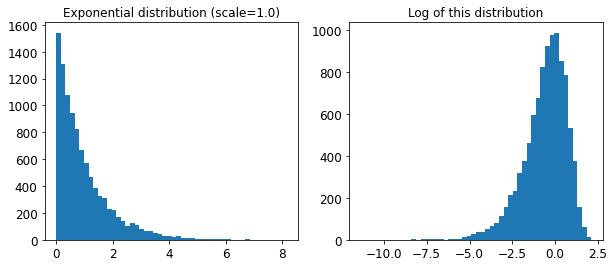

In [119]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

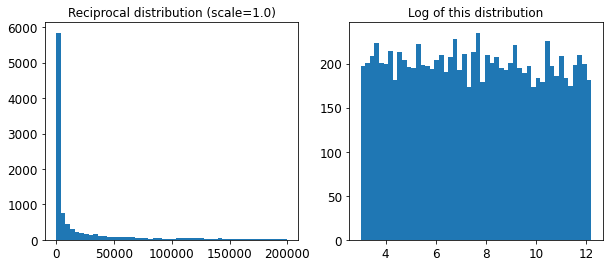

In [120]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Aufgabe: Versuchen Sie, einen Transformator in die Vorbereitungspipeline einzufügen, um nur die wichtigsten Attribute auszuwählen.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [ ]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!  :)

## 4.

Aufgabe: Versuchen Sie, eine einzige Pipeline zu erstellen, die die gesamte Datenaufbereitung und die endgültige Vorhersage übernimmt.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Aufgabe: Erkunden Sie automatisch einige Vorbereitungsoptionen mit `GridSearchCV`.

**Warnung**: Die Ausführung der folgenden Zelle kann bis zu 45 Minuten dauern, je nach Ihrer Hardware auch länger.

**Anmerkung:** Im folgenden Code habe ich den Hyperparameter "handle_unknown" des `OneHotEncoder` auf "ignore" gesetzt, um Warnungen während des Trainings zu vermeiden. Ohne dies würde der `OneHotEncoder` standardmäßig auf `handle_unknown='error'` gesetzt, was bedeutet, dass er einen Fehler auslösen würde, wenn er Daten transformiert, die eine Kategorie enthalten, die er beim Training nicht gesehen hat. Wenn wir die Voreinstellung beibehalten, dann würde `GridSearchCV` während des Trainings auf Fehler stoßen, wenn die Folds ausgewertet werden, in denen nicht alle Kategorien im Trainingssatz enthalten sind. Dies ist wahrscheinlich, da es nur ein Datenpunkt in der Kategorie `'ISLAND'` gibt, die in einigen der Folds in der Testmenge landen könnte. Einige Folds würden also von `GridSearchCV` einfach fallen gelassen werden, und das ist am besten zu vermeiden.

In [ ]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   4.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   5.2s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   4.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   4.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   4.8s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   5.1s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   4.9s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 42.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [ ]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

Die beste Imputer-Strategie ist `most_frequent` und offenbar sind fast alle Merkmale nützlich (15 von 16). Das letzte Merkmal (`ISLAND`) scheint nur etwas Rauschen hinzuzufügen.

Congratulations! You already know quite a lot about Machine Learning. :)